In [1]:
import numpy as np
from sklearn import base, metrics
from sklearn.model_selection import KFold
import pandas as pd
from classifiers import *
from data_generation import *

## Data Viz

In [2]:
## Number of dimensions and classes
k = 3

## Number of data points
n = 1000

In [3]:
X,y = generate_simplex_data(k,n)

In [4]:
## Visualize Data Set
from matplotlib import pyplot as plt
fig=plt.figure(figsize=(6,6))
plt.scatter([X[:, 0]], [X[:, 1]], c=y.T)

## Metrics and Code Needed to Perform Tests

In [5]:
def weighted_absolute_loss(u, y, alpha):
    y = np.array(y.T[0]) ## y is given as a column matrix, but predictions are not
    zs = np.zeros_like(y)
    return np.mean((1 - alpha) * np.maximum((u - y), zs) + alpha * np.maximum((y - u), zs))

In [6]:
def compute_alpha_quantile(X, alpha):
    n = X.shape[0]
    y = np.zeros((n, 1))
    w_alpha = alpha * 10 ## Simplex weighted to be 10 x 10
    for i in range(0, n):
        curr_vec = X[i,:]
        
        if(w_alpha < curr_vec[0]):
            y[i, 0] = 0
        elif(w_alpha  > curr_vec[-1]):
            y[i,0] = k - 1
        else:
            y[i,0] = np.argmax(curr_vec > w_alpha)
    return y

## Cross-Validation (Small Scale)

In [ ]:
k = 3
n = 1000
a1, a2, a3 = 0.3, 0.5, 0.75

X_train,y_train = generate_simplex_data(k,n)
y_train = y_train.astype(int)

X_test,y_test = generate_simplex_data(k,n)

In [ ]:
## Cross Validation for rbf and polynomial kernel
quantiles = [a1, a2, a3]

reg_vals = [10**(-2), 10**(-1)]
q_vals = [2, 3]
gamma_vals = [10**(-1), 10**0]

cv_results_file = open('cv_results.csv', "w")
cv_results_file.write('Fold,Quantile,Surrogate,Kernel_Type,Kernel_Parameter,Regularization,01_Loss\n')
kf = KFold(n_splits=2)
kf.get_n_splits(X_train)
fold = 0
for train_index, test_index in kf.split(X_train):
    fold += 1
    curr_X_train, curr_X_test = X_train[train_index], X_train[test_index]
    curr_y_train, curr_y_test = y_train[train_index], y_train[test_index]
    for a in quantiles:
        print('Fold ' + str(fold) + ' Quantile ' + str(a))
        a_test_quantiles = compute_alpha_quantile(curr_X_test, a)
        for reg in reg_vals:
            for q in q_vals:
                clf1 = LogisticQuantileIT(gamma=a, alpha=1., kernel_type='poly', kernel_param=q)
                clf1.fit(curr_X_train, curr_y_train)
                lossIT = metrics.zero_one_loss(clf1.predict(curr_X_test), a_test_quantiles , normalize=False)
                result_string = str(fold) + ',' + str(a) + ',' + 'IT' + ',' + 'poly' + ',' + str(q) + ',' + str(reg) + ',' + str(lossIT)
                cv_results_file.write(result_string + '\n')

                clf2 = LogisticQuantileAT(gamma=a, alpha=1., kernel_type='poly', kernel_param=q)
                clf2.fit(curr_X_train, curr_y_train)
                lossAT = metrics.zero_one_loss(clf2.predict(curr_X_test), a_test_quantiles , normalize=False)
                result_string = str(fold) + ',' + str(a) + ',' + 'AT' + ',' + 'poly' + ','+ str(q) + ',' + str(reg) + ',' + str(lossAT)
                cv_results_file.write(result_string + '\n')
                
            for g in gamma_vals:
                clf1 = LogisticQuantileIT(gamma=a, alpha=1., kernel_type='rbf', kernel_param=g)
                clf1.fit(curr_X_train, curr_y_train)
                lossIT = metrics.zero_one_loss(clf1.predict(curr_X_test), a_test_quantiles , normalize=False)
                result_string = str(fold) + ',' + str(a) + ',' + 'IT' + ',' + 'rbf' + ',' + str(g) + ',' + str(reg) + ',' + str(lossIT)
                cv_results_file.write(result_string + '\n')

                clf2 = LogisticQuantileAT(gamma=a, alpha=1., kernel_type='rbf', kernel_param=g)
                clf2.fit(curr_X_train, curr_y_train)
                lossAT = metrics.zero_one_loss(clf2.predict(curr_X_test), a_test_quantiles , normalize=False)
                result_string = str(fold) + ',' + str(a) + ',' + 'AT' + ',' + 'rbf' + ',' + str(g) + ',' + str(reg) + ',' + str(lossAT)
                cv_results_file.write(result_string + '\n')
    
cv_results_file.close()

In [ ]:
cv_results_from = pd.read_csv('cv_results.csv')
cv_results_from

## Tests

In [7]:
k = 3
n = 10000
a1, a2, a3 = 0.3, 0.5, 0.75

X_train,y_train = generate_simplex_data(k,n)
y_train = y_train.astype(int)

X_test,y_test = generate_simplex_data(k,n)

In [8]:
def train_classifiers(X_train, y_train, X_test, y_test, a, 
                      kernel='linear', kernel_param=1, loss_function='logistic'):
    results = {}
    y_quantiles = compute_alpha_quantile(X_test, a).astype(int)
    clf5 = LogisticQuantileIT(gamma=a, alpha=0.01, kernel_type=kernel, 
                              kernel_param=kernel_param, loss_function=loss_function)
    clf5.fit(X_train, y_train)
    preds_5 = clf5.predict(X_test)
    abs_loss = weighted_absolute_loss(preds_5, y_test, a)
    zo_loss = metrics.zero_one_loss(preds_5, y_quantiles)
    print('Weighted Absolute Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf5] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss, 'Preds': preds_5}

    clf6 = LogisticQuantileAT(gamma=a, alpha=1., kernel_type=kernel, 
                              kernel_param=kernel_param, loss_function=loss_function)
    clf6.fit(X_train, y_train)
    preds_6 = clf6.predict(X_test)
    zo_loss = metrics.zero_one_loss(preds_6, y_quantiles)
    abs_loss = weighted_absolute_loss(preds_6, y_test, a)
    print('Weighted Absolute Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf6] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss, 'Preds': preds_6}
    return results

In [9]:
results = train_classifiers(X_train, y_train, X_test, y_test, 0.3, 
                            kernel='linear', kernel_param=3, loss_function='hinge')

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0. 0. 0. 1.]
[1.e-08 0.e+00 0.e+00 1.e+00]
[0.e+00 1.e-08 0.e+00 1.e+00]
[0.e+00 0.e+00 1.e-08 1.e+00]
[0.         0.         0.         1.00000001]
[-0.48552724 -0.87410632  0.01419284  0.99996164]
[-0.48552723 -0.87410632  0.01419284  0.99996164]
[-0.48552724 -0.87410631  0.01419284  0.99996164]
[-0.48552724 -0.87410632  0.01419285  0.99996164]
[-0.48552724 -0.87410632  0.01419284  0.99996165]
[-0.10454182 -0.18820915  0.00305595  0.99999174]
[-0.10454181 -0.18820915  0.00305595  0.99999174]
[-0.10454182 -0.18820914  0.00305595  0.99999174]
[-0.10454182 -0.18820915  0.00305596  0.99999174]
[-0.10454182 -0.18820915  0.00305595  0.99999175]
[-0.03646277 -0.0656448   0.00106587  0.99999712]
[-0.03646276 -0.0656448   0.00106587  0.99999712]
[-0.03646277 -0.06564479  0.00106587  0.99999712]
[-0.03646277 -0.0656448   0.00106588  0.99999712]
[-0.03646277 -0.0656448   0.00106587  0.99999713]
[-0.070078   -0.08707882  0.00294929  0.996071  ]
[-0.07007799 -0.08707882  0.00294929  0.996071  ]


[ 5.95460635e-05 -2.09074189e-03  9.89686487e-01  0.00000000e+00]
[ 5.95360635e-05 -2.09073189e-03  9.89686487e-01  0.00000000e+00]
[ 5.95360635e-05 -2.09074189e-03  9.89686497e-01  0.00000000e+00]
[ 5.95360635e-05 -2.09074189e-03  9.89686487e-01  1.00000000e-08]
[-0.00123811  0.00844482  1.04902828  0.        ]
[-0.0012381   0.00844482  1.04902828  0.        ]
[-0.00123811  0.00844483  1.04902828  0.        ]
[-0.00123811  0.00844482  1.04902829  0.        ]
[-1.23810629e-03  8.44481760e-03  1.04902828e+00  1.00000000e-08]
[-5.46087483e-05 -1.16400005e-03  9.94906382e-01  0.00000000e+00]
[-5.45987483e-05 -1.16400005e-03  9.94906382e-01  0.00000000e+00]
[-5.46087483e-05 -1.16399005e-03  9.94906382e-01  0.00000000e+00]
[-5.46087483e-05 -1.16400005e-03  9.94906392e-01  0.00000000e+00]
[-5.46087483e-05 -1.16400005e-03  9.94906382e-01  1.00000000e-08]
[-0.01986975  0.03787856  1.13563084  0.        ]
[-0.01986974  0.03787856  1.13563084  0.        ]
[-0.01986975  0.03787857  1.13563084  0.

[2.69944731e-04 3.64359820e-04 1.00383022e+00 0.00000000e+00]
[2.69944731e-04 3.64349820e-04 1.00383023e+00 0.00000000e+00]
[2.69944731e-04 3.64349820e-04 1.00383022e+00 1.00000000e-08]
[-2.35653886e-05 -1.98053668e-05  9.99735218e-01  4.09090043e-05]
[-2.35553886e-05 -1.98053668e-05  9.99735218e-01  4.09090043e-05]
[-2.35653886e-05 -1.97953668e-05  9.99735218e-01  4.09090043e-05]
[-2.35653886e-05 -1.98053668e-05  9.99735228e-01  4.09090043e-05]
[-2.35653886e-05 -1.98053668e-05  9.99735218e-01  4.09190043e-05]
[1.23189671e-04 1.72272227e-04 1.00178272e+00 2.04545021e-05]
[1.23199671e-04 1.72272227e-04 1.00178272e+00 2.04545021e-05]
[1.23189671e-04 1.72282227e-04 1.00178272e+00 2.04545021e-05]
[1.23189671e-04 1.72272227e-04 1.00178273e+00 2.04545021e-05]
[1.23189671e-04 1.72272227e-04 1.00178272e+00 2.04645021e-05]
[-1.78570407e-05 -1.23341033e-05  9.99814860e-01  4.01133832e-05]
[-1.78470407e-05 -1.23341033e-05  9.99814860e-01  4.01133832e-05]
[-1.78570407e-05 -1.23241033e-05  9.998148

[2.23070074e-07 1.81750091e-07 1.00000155e+00 1.00000000e-08]
[-1.90744448e-07 -2.26155897e-07  9.99997431e-01  7.47239990e-07]
[-1.80744448e-07 -2.26155897e-07  9.99997431e-01  7.47239990e-07]
[-1.90744448e-07 -2.16155897e-07  9.99997431e-01  7.47239990e-07]
[-1.90744448e-07 -2.26155897e-07  9.99997441e-01  7.47239990e-07]
[-1.90744448e-07 -2.26155897e-07  9.99997431e-01  7.57239990e-07]
[-1.08195548e-07 -7.96452261e-08  9.99998952e-01  0.00000000e+00]
[-9.81955476e-08 -7.96452261e-08  9.99998952e-01  0.00000000e+00]
[-1.08195548e-07 -6.96452261e-08  9.99998952e-01  0.00000000e+00]
[-1.08195548e-07 -7.96452261e-08  9.99998962e-01  0.00000000e+00]
[-1.08195548e-07 -7.96452261e-08  9.99998952e-01  1.00000000e-08]
[-1.72235036e-07 -1.93304746e-07  9.99997772e-01  5.79691142e-07]
[-1.62235036e-07 -1.93304746e-07  9.99997772e-01  5.79691142e-07]
[-1.72235036e-07 -1.83304746e-07  9.99997772e-01  5.79691142e-07]
[-1.72235036e-07 -1.93304746e-07  9.99997782e-01  5.79691142e-07]
[-1.72235036e-

Weighted Absolute Loss of LogisticQuantileIT, gamma=0.3 0.30158999999999997
0-1 Loss of LogisticQuantileIT, gamma=0.3 0.5095000000000001
[0. 0. 0. 1.]
[1.e-08 0.e+00 0.e+00 1.e+00]
[0.e+00 1.e-08 0.e+00 1.e+00]
[0.e+00 0.e+00 1.e-08 1.e+00]
[0.         0.         0.         1.00000001]
[-0.52594959 -0.85038566 -0.01487459  0.99997608]
[-0.52594958 -0.85038566 -0.01487459  0.99997608]
[-0.52594959 -0.85038565 -0.01487459  0.99997608]
[-0.52594959 -0.85038566 -0.01487458  0.99997608]
[-0.52594959 -0.85038566 -0.01487459  0.99997609]
[-0.11499178 -0.18592535 -0.00325213  0.99999477]
[-0.11499177 -0.18592535 -0.00325213  0.99999477]
[-0.11499178 -0.18592534 -0.00325213  0.99999477]
[-0.11499178 -0.18592535 -0.00325212  0.99999477]
[-0.11499178 -0.18592535 -0.00325213  0.99999478]
[-3.32106616e-02 -5.36969156e-02 -9.39244013e-04  9.99998489e-01]
[-3.32106516e-02 -5.36969156e-02 -9.39244013e-04  9.99998489e-01]
[-3.32106616e-02 -5.36969056e-02 -9.39244013e-04  9.99998489e-01]
[-3.32106616e-0

[-0.27098877 -0.13783813 -1.86043642  1.50707877]
[-0.27098877 -0.13783814 -1.86043641  1.50707877]
[-0.27098877 -0.13783814 -1.86043642  1.50707878]
[-0.27098929 -0.13783784 -1.86043661  1.50707989]
[-0.27098928 -0.13783784 -1.86043661  1.50707989]
[-0.27098929 -0.13783783 -1.86043661  1.50707989]
[-0.27098929 -0.13783784 -1.8604366   1.50707989]
[-0.27098929 -0.13783784 -1.86043661  1.5070799 ]
[-0.27098908 -0.13783797 -1.86043653  1.50707943]
[-0.27098907 -0.13783797 -1.86043653  1.50707943]
[-0.27098908 -0.13783796 -1.86043653  1.50707943]
[-0.27098908 -0.13783797 -1.86043652  1.50707943]
[-0.27098908 -0.13783797 -1.86043653  1.50707944]
[-0.27098888 -0.13783808 -1.86043646  1.50707899]
[-0.27098887 -0.13783808 -1.86043646  1.50707899]
[-0.27098888 -0.13783807 -1.86043646  1.50707899]
[-0.27098888 -0.13783808 -1.86043645  1.50707899]
[-0.27098888 -0.13783808 -1.86043646  1.507079  ]
[-0.27098901 -0.13783801 -1.86043651  1.50707927]
[-0.270989   -0.13783801 -1.86043651  1.50707927]


### Plot Decision Boundaries

LogisticQuantileIT(alpha=0.01, gamma=0.3, kernel_param=3,
          kernel_type='linear', loss_function='hinge', max_iter=1000,
          verbose=0)
[0.99999843 0.99999858]


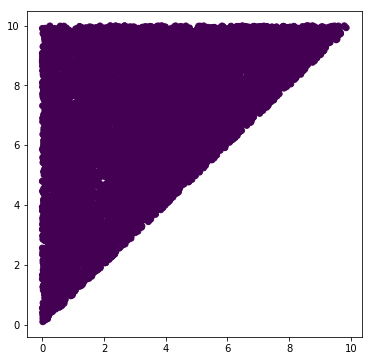

LogisticQuantileAT(alpha=1.0, gamma=0.3, kernel_param=3, kernel_type='linear',
          loss_function='hinge', max_iter=1000, verbose=0)
[-1.86043648 -0.35335738]


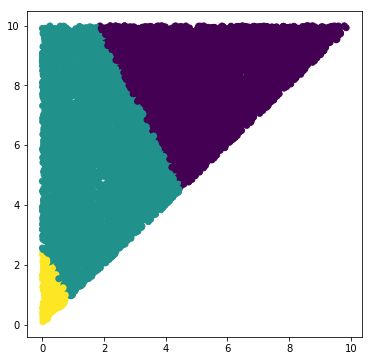

In [10]:
curr = results
for clf in curr.keys():
    print(clf)   
    print(clf.theta_)
    fig=plt.figure(figsize=(6,6))
    plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=[curr[clf]['Preds'].T])
    plt.show()

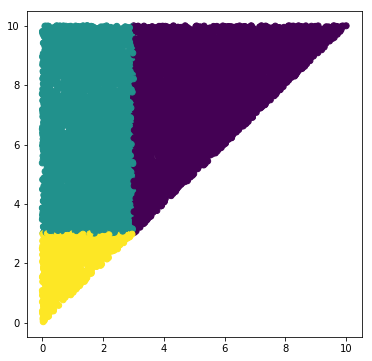

In [25]:
y_quantiles = compute_alpha_quantile(X_test, a1).astype(int)
fig=plt.figure(figsize=(6,6))
plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=y_quantiles.T)